In [8]:
# import module

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
import pandas as pd

In [9]:
# load data

d = np.load("C:/Users/kotor/StarGen/datasets/mass_ppv/2200.npz")
m = d["arr_2"]

rv = d['arr_0']
pc = d['arr_1']

<>:27: SyntaxWarning:

invalid escape sequence '\o'

<>:27: SyntaxWarning:

invalid escape sequence '\o'

C:\Users\kotor\AppData\Local\Temp\ipykernel_15820\1505176727.py:27: SyntaxWarning:

invalid escape sequence '\o'



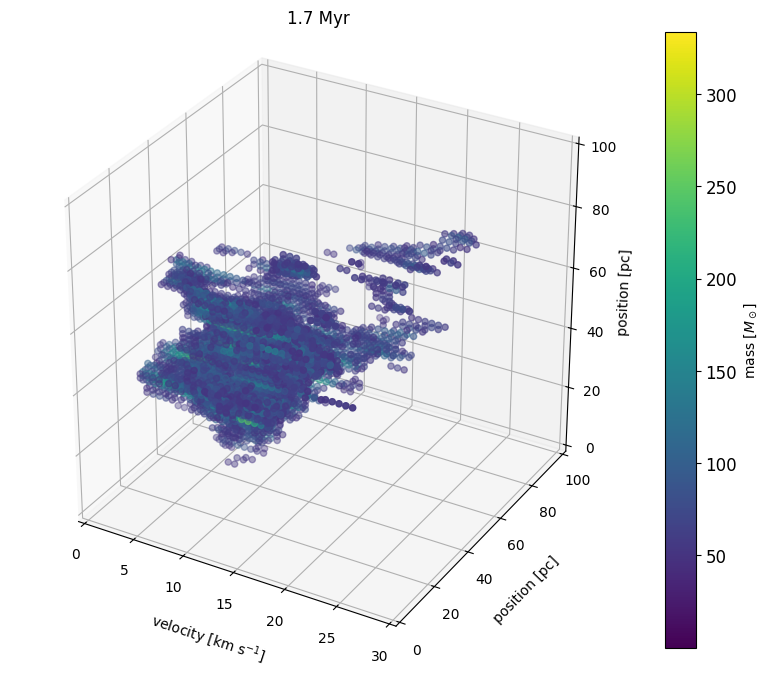

In [10]:
# make 3D map

shape = m.shape
gas_mass = m.reshape(-1)
colormap = plt.get_cmap('viridis')
norm = plt.Normalize(gas_mass.min(), gas_mass.max())

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

x_coords = np.repeat(np.arange(shape[0]), shape[1]*shape[2]) * rv
y_coords = np.tile(np.repeat(np.arange(shape[1]), shape[2]), shape[0]) * pc
z_coords = np.tile(np.arange(shape[2]), shape[0]*shape[1]) * pc

threshold = 50
mask= gas_mass > threshold

x_filtered = x_coords[mask]
y_filtered = y_coords[mask]
z_filtered = z_coords[mask]
gas_mass_filtered = gas_mass[mask]

scatter = ax.scatter(x_filtered, y_filtered, z_filtered, c=gas_mass_filtered, cmap=colormap, norm=norm)  

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('mass [$M_\odot$]')
cbar.ax.tick_params(labelsize=12)

ax.set_xlim3d(0, 30)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)

plt.title("1.7 Myr")

X = ax.set_xlabel('velocity [km s$^{-1}$]', labelpad=10)
Y = ax.set_ylabel('position [pc]', labelpad=10)
Z = ax.set_zlabel('position [pc]', labelpad=4)

In [11]:
# compute dendrogram

dendro = Dendrogram.compute(m, min_value=90, min_delta=20, min_npix=50)

In [12]:
# make feature list

leaf_indices = [i for i, structure in enumerate(dendro) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro) if structure.is_branch]

leaf_npix, branch_npix = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    npix = structure.get_npix() 
    leaf_npix.append(npix)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    npix = structure.get_npix()
    branch_npix.append(npix)    
leaf_sizes = np.array(leaf_npix) * rv * pc**2
branch_sizes = np.array(branch_npix) * rv * pc**2

mass_per_leaf, mass_per_branch = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    leaf_mass = np.sum(m[indices])
    mass_per_leaf.append(leaf_mass)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    branch_mass = np.sum(m[indices])
    mass_per_branch.append(branch_mass)
mass_per_leaf = np.array(mass_per_leaf)
mass_per_branch = np.array(mass_per_branch)

x_peak, y_peak, z_peak, peak_value = [], [], [], []
for s in dendro.leaves:
    x_ch, y_ch, z_ch = s.get_peak()[0]
    value = s.get_peak()[1]
    x_peak.append(round(float(x_ch), 6) * rv)
    y_peak.append(round(float(y_ch), 6) * pc)
    z_peak.append(round(float(z_ch), 6) * pc)
    peak_value.append(round(float(value), 6))

leaf_radius = np.cbrt(3 * (np.array(leaf_sizes)) / (4 * np.pi)) 
branch_radius = np.cbrt(3 * (np.array(branch_sizes)) / (4 * np.pi))

delta_rv_leaf, delta_rv_branch = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    rv_indices = indices[0] * rv
    delta_rv = np.var(rv_indices)
    delta_rv_leaf.append(delta_rv)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    rv_indices = indices[0] * rv
    delta_rv = np.var(rv_indices)
    delta_rv_branch.append(delta_rv)

vir_leaf = (1.2 * 10**3 * np.array(leaf_radius) * np.array(delta_rv_leaf)**2 / (3 * np.array(mass_per_leaf)))
vir_branch = (1.2 * 10**3 * np.array(branch_radius) * np.array(delta_rv_branch)**2 / (3 * np.array(mass_per_branch)))

leaf_feature = pd.DataFrame({
    'id':leaf_indices, 
    'leaf_size [pc^2]':leaf_sizes, 
    'leaf_mass [solar mass]':mass_per_leaf,
    'v_peak':x_peak, 
    'y_peak':y_peak,
    'z_peak':z_peak, 
    'peak_value [solar mass]':peak_value,
    'leaf_radius [pc]':leaf_radius,
    'velocity dispersion [km/s]':delta_rv_leaf,
    'virial_parameter':vir_leaf})
branch_feature = pd.DataFrame({
    'id':branch_indices, 
    'branch_size [pc^2]':branch_sizes, 
    'branch_mass [solar mass]':mass_per_branch,
    'branch_radius [pc]':branch_radius,
    'velocity dispersion [km/s]':delta_rv_branch,
    'virial_parameter':vir_branch})

leaf_size_ave = np.sum(leaf_sizes) / len(leaf_indices)
branch_size_ave = np.sum(branch_sizes) / len(branch_indices)
leaf_mass_ave = np.sum(mass_per_leaf) / len(leaf_indices)
branch_mass_ave = np.sum(mass_per_branch) / len(branch_indices)
leaf_vir_ave = np.sum(vir_leaf) / len(leaf_indices)
branch_vir_ave = np.sum(vir_branch) / len(branch_indices)

display(leaf_feature)
print('leaf size average:', leaf_size_ave)
print('leaf mass average:', leaf_mass_ave)
print('leaf virial parameter average:', leaf_vir_ave)
display(branch_feature)
print('branch size average:', branch_size_ave)
print('branch mass average:', branch_mass_ave)
print('branch virial parameter average:', branch_vir_ave)


,id,leaf_size [pc^2],leaf_mass [solar mass],v_peak,y_peak,z_peak,peak_value [solar mass],leaf_radius [pc],velocity dispersion [km/s],virial_parameter
0,0,139.501090,13999.434742,10.40,31.838379,24.916992,248.489913,3.217335,9.105171,7.621177
1,1,1311.559356,135441.753576,7.15,44.296875,35.991211,256.499916,6.790469,8.468951,1.438356
2,4,64.768363,6966.605924,3.90,38.759766,24.916992,231.580835,2.491293,2.955000,1.249046
3,6,74.732727,11189.882619,4.55,42.912598,52.602539,200.976587,2.613008,2.947524,0.811503
4,7,188.077362,27096.057442,5.85,47.065430,44.296875,253.513830,3.554261,3.602433,0.680918
5,8,198.041726,19863.546048,8.45,47.065430,23.532715,221.024260,3.615952,1.962174,0.280350
6,9,73.487181,11147.012879,8.45,56.755371,35.991211,333.830668,2.598410,1.397976,0.182225
7,10,80.960454,9412.006401,9.10,55.371094,33.222656,211.695893,2.683664,2.042400,0.475760


leaf size average: 266.3910324499011
leaf mass average: 29389.537454009533
leaf virial parameter average: 1.5924169657485419


,id,branch_size [pc^2],branch_mass [solar mass],branch_radius [pc],velocity dispersion [km/s],virial_parameter
0,2,575.441996,71471.532566,5.159857,6.954365,1.396624
1,3,95.906999,13840.749848,2.839579,5.546301,2.524417
2,5,103.380272,9883.989532,2.911497,2.292748,0.619379


branch size average: 258.24308931827545
branch mass average: 31732.090648610294
branch virial parameter average: 1.5134736316778434


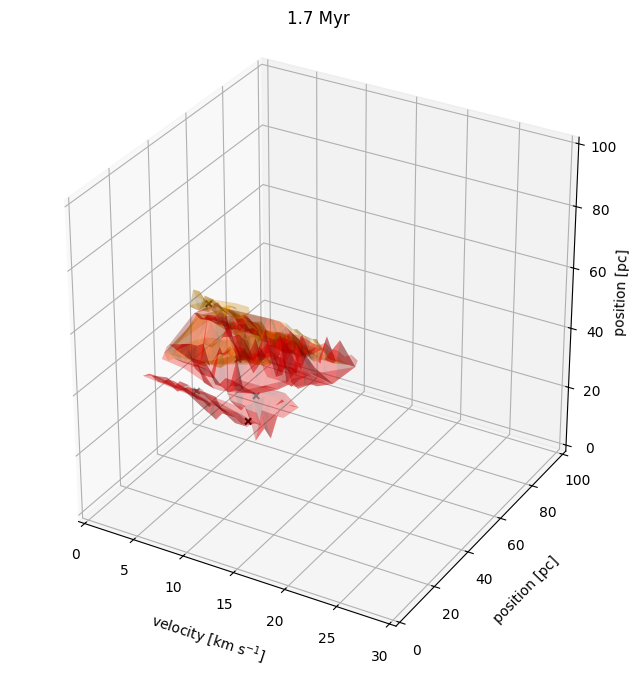

In [13]:
# plot the contour

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

for i, structure_index in enumerate(leaf_indices):
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.plot_trisurf(indices[0] * rv, indices[1] * pc, indices[2] * pc, color='red', alpha=0.3)
for j, structure_index in enumerate(branch_indices):
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.plot_trisurf(indices[0] * rv, indices[1] * pc, indices[2] * pc, color='orange', alpha=0.3)

ax.scatter(leaf_feature['v_peak'], leaf_feature['y_peak'], leaf_feature['z_peak'], marker='x', color='black')

ax.set_xlim3d(0, 30)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)

plt.title("1.7 Myr")

X = ax.set_xlabel('velocity [km s$^{-1}$]', labelpad=10)
Y = ax.set_ylabel('position [pc]', labelpad=10)
Z = ax.set_zlabel('position [pc]', labelpad=3)

In [14]:
# plot by plotly

fig = px.scatter_3d(leaf_feature, x='v_peak', y='y_peak', z='z_peak')

# Leaf structures
for i, leaf_structure_index in enumerate(leaf_indices):
    leaf_structure = dendro[leaf_structure_index]
    leaf_mask = leaf_structure.get_mask()
    leaf_mask_indices = np.where(leaf_mask)
    mesh_leaf = go.Mesh3d(x=leaf_mask_indices[0] * rv, 
                          y=leaf_mask_indices[1] * pc, 
                          z=leaf_mask_indices[2] * pc, 
                          opacity=0.3,
                          color='red',
                          name=f'Leaf {i + 1} - Surface')
    fig.add_trace(mesh_leaf)

# Branch structures
for j, branch_structure_index in enumerate(branch_indices):
    branch_structure = dendro[branch_structure_index]
    branch_mask = branch_structure.get_mask()
    branch_mask_indices = np.where(branch_mask)
    mesh_branch = go.Mesh3d(x=branch_mask_indices[0] * rv, 
                            y=branch_mask_indices[1] * pc, 
                            z=branch_mask_indices[2] * pc,
                            opacity=0.3, 
                            color='orange',
                            name=f'Branch {j + 1} - Surface')
    fig.add_trace(mesh_branch)

fig.update_layout(
    scene=dict(
        xaxis=dict(title='radial velocity [km/s]', range=[0, 30]),
        yaxis=dict(title='Y [pc]', range=[0, 100]),
        zaxis=dict(title='Z [pc]', range=[0, 100]),
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Structure Contours in 3D with Mesh Surface',
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True)
